In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, _ in os.walk("/kaggle/input/face-mask-12k-images-dataset"):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-12k-images-dataset
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithMask
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask


In [2]:
!pip list | grep "torch\|cuda\|fast\|timm"

cuda-python                            11.8.1
dask-cuda                              23.4.0
fastai                                 2.7.12
fastapi                                0.95.0
fastavro                               1.7.3
fastcore                               1.5.29
fastdownload                           0.0.7
fasteners                              0.18
fastjsonschema                         2.16.3
fastprogress                           1.0.3
fastrlock                              0.8
fasttext                               0.9.2
jaxlib                                 0.4.7+cuda11.cudnn82
pycuda                                 2022.2.2
pyfasttext                             0.4.6
pytorch-ignite                         0.4.11
pytorch-lightning                      2.0.1.post0
timm                                   0.6.13
torch                                  2.0.0
torchaudio                             2.0.1
torchdata                              0.6.0
torchinfo                 

In [3]:
import gc, cv2
import pandas as pd
import albumentations as A
from fastai.vision.all import *
from fastai.test_utils import *
import matplotlib.pyplot as plt
from scipy.spatial import distance

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
face_model = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_default.xml')

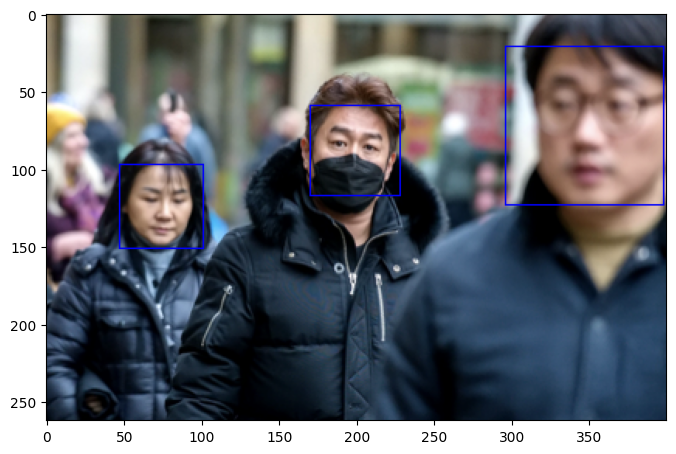

In [5]:
img = cv2.imread('/kaggle/input/face-mask-detection/images/maksssksksss244.png')
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
    
plt.figure(figsize=(8,8))
_ = plt.imshow(out_img)

In [6]:
MIN_DISTANCE = 130

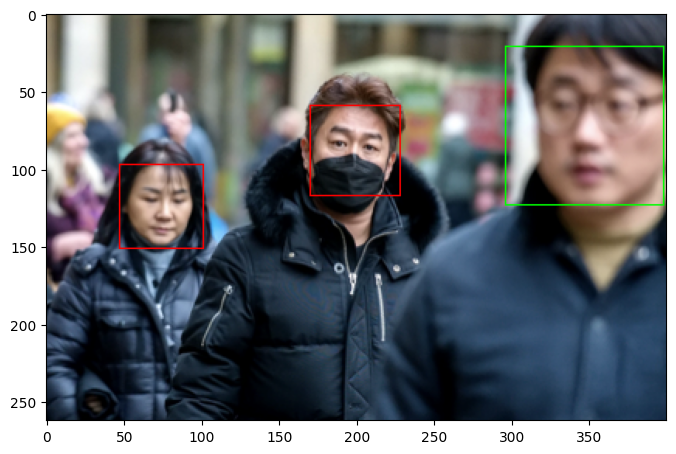

In [7]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist < MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
                
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
            
    plt.figure(figsize=(8,8))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_val = 111
seed_everything(seed_val)

In [9]:
arch = 'convnext_small_384_in22ft1k'
loss_func = CrossEntropyLossFlat()
metrics = [accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted'), BalancedAccuracy()]

In [10]:
# Source: https://forums.fast.ai/t/albumentation-transformations-for-train-and-test-dataset/82642
class AlbumentationsTransform(RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def get_train_aug(): 
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
        A.OneOf([
                    A.CLAHE(),
                    A.HueSaturationValue(0.2, 0.2, 0.2, p=0.5)
                ],p=0.4),
        A.OneOf([
                    A.MotionBlur(p=.2),
                    A.MedianBlur(blur_limit=3, p=0.1),
                    A.Blur(blur_limit=3, p=0.1),
                ], p=0.2),
    ])

def get_valid_aug():
    return A.Compose([], p=1.0)

In [11]:
data_path = "../input/face-mask-12k-images-dataset/Face Mask Dataset"
trn_path = f"{data_path}/Train"
val_path = f"{data_path}/Validation"
tst_path = f"{data_path}/Test"

In [12]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, get_image_files(data_path), n_workers=8)
pd.Series(sizes).value_counts()

(224, 224)    4990
(107, 107)     276
(105, 105)     272
(106, 106)     261
(102, 102)     258
              ... 
(338, 338)       1
(156, 156)       1
(155, 155)       1
(179, 179)       1
(284, 284)       1
Length: 142, dtype: int64

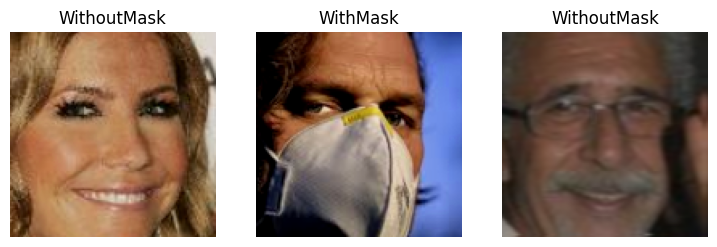

In [13]:
dls = ImageDataLoaders.from_folder(
    data_path, train="Train", valid='Validation',
    item_tfms=[Resize(128), AlbumentationsTransform(get_train_aug(), get_valid_aug())], 
    batch_tfms=Normalize.from_stats(*imagenet_stats), 
    bs=64, seed=seed_val)

dls.show_batch(max_n=3)

In [14]:
learn = vision_learner(dls, arch, metrics=metrics, path='.', cbs=CSVLogger()).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_1k_384.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_1k_384.pth


SuggestedLRs(valley=0.0005754399462603033)

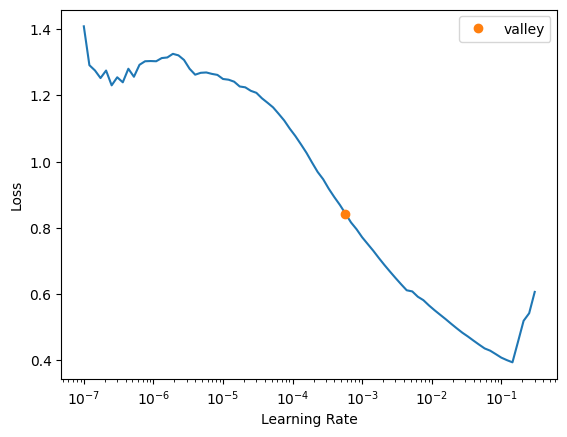

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(
    10,
    0.0001
)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.301295,0.072639,0.980000,0.980108,0.980000,0.979999,0.980000,00:48
1,0.067227,0.013087,0.996250,0.996253,0.996250,0.996250,0.996250,00:47
2,0.026351,0.005205,0.998750,0.998753,0.998750,0.998750,0.998750,00:47
3,0.017444,0.003408,0.997500,0.997512,0.997500,0.997500,0.997500,00:45
4,0.008794,0.002316,0.998750,0.998753,0.998750,0.998750,0.998750,00:46
5,0.007077,0.001366,0.998750,0.998753,0.998750,0.998750,0.998750,00:45
6,0.005765,0.000636,1.000000,1.000000,1.000000,1.000000,1.000000,00:46
7,0.005131,0.001044,1.000000,1.000000,1.000000,1.000000,1.000000,00:46
8,0.005274,0.000527,1.000000,1.000000,1.000000,1.000000,1.000000,00:45
9,0.003740,0.000838,1.000000,1.000000,1.000000,1.000000,1.000000,00:46


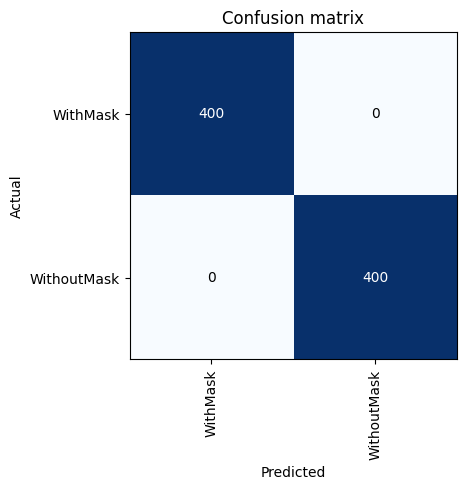

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [18]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    history = pd.read_csv('/kaggle/working/history.csv').drop(columns=['epoch', 'time'])
    metrics = history.values
    names = history.columns
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

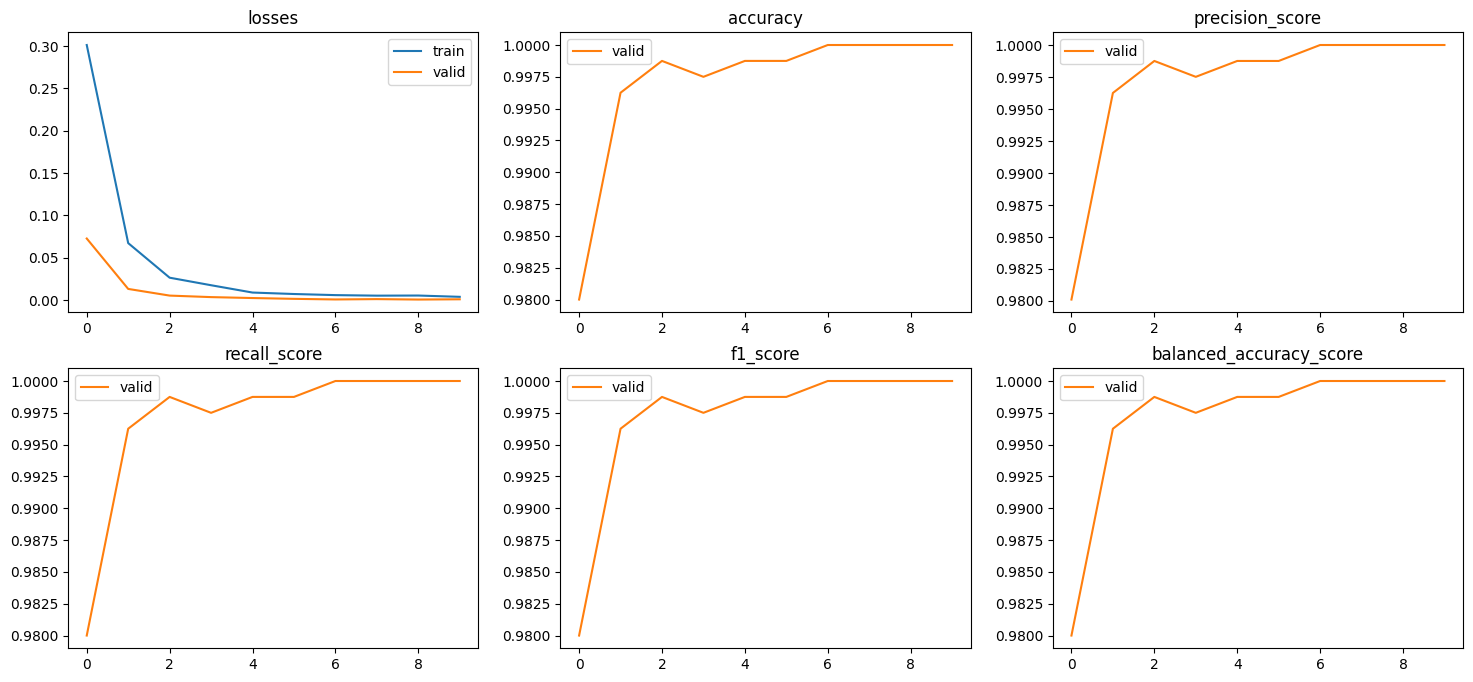

In [19]:
learn.recorder.plot_metrics()

In [20]:
dls_tmp = ImageDataLoaders.from_folder(
    data_path, train="Train", valid='Test',
    item_tfms=[Resize(128)])

_, targs = learn.get_preds(dl=dls_tmp.valid)

In [21]:
test_dl = dls.test_dl(get_image_files(tst_path), bs=32, with_label=True)
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [22]:
accuracy(preds, targs)

TensorBase(1.)

In [23]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

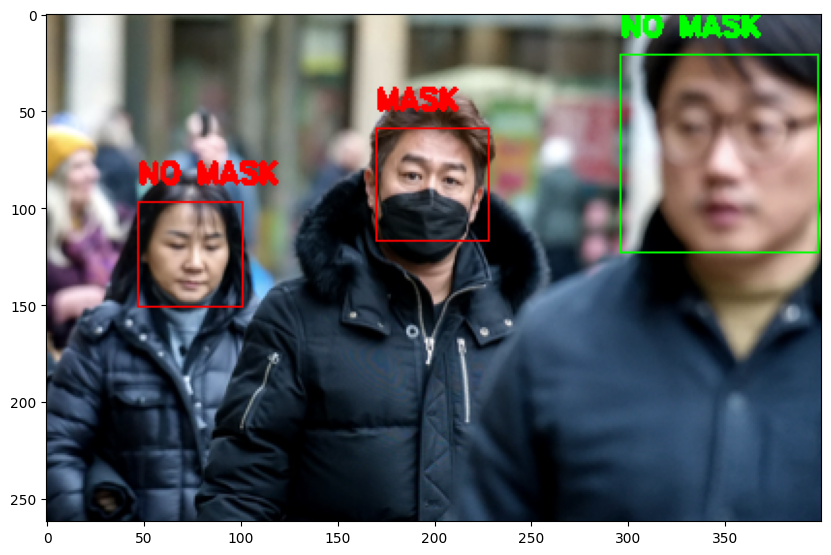

In [24]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        mask_result = learn.predict(crop)
        cv2.putText(new_img,mask_label[mask_result[1].item()],(x, y-10),cv2.FONT_HERSHEY_DUPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")